# Abstractive Summarization using LongformerEncoderDecoder (LED) on MultiNews

This notebook shows how to fine-tune and visualize attention in the `allenai/led-base-16384` model for multi-document summarization using the **MultiNews** dataset.


In [1]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!pip install transformers datasets torch accelerate rouge_score  --quiet

## 🔹 Step 1: Load MultiNews Dataset

We use a small 1% subset of the `multi_news` dataset to reduce training time.


In [ ]:
from datasets import load_dataset
from transformers import LEDTokenizer, LEDForConditionalGeneration, TrainingArguments, Trainer
import torch

# Load MultiNews dataset (subset for speed)
dataset = load_dataset("multi_news", split="train[:1%]")  # small subset

## 🔹 Step 2: Load Pretrained LED Model and Tokenizer


In [ ]:
# Load model & tokenizer
model_name = "allenai/led-base-16384"
tokenizer = LEDTokenizer.from_pretrained(model_name)
model = LEDForConditionalGeneration.from_pretrained(model_name)

## 🔹 Step 3: Preprocess and Tokenize the Dataset

Includes setting up global attention masks on the first token.


In [ ]:
# Preprocessing
max_input_length = 4096
max_target_length = 256

def preprocess_function(examples):
    inputs = tokenizer(
        examples["document"],
        padding="max_length",
        truncation=True,
        max_length=max_input_length,
        return_tensors="pt"
    )

    with tokenizer.as_target_tokenizer():
        targets = tokenizer(
            examples["summary"],
            padding="max_length",
            truncation=True,
            max_length=max_target_length,
            return_tensors="pt"
        )

    input_ids = inputs["input_ids"]
    attention_mask = inputs["attention_mask"]

    # Global attention on <s> token (token ID 0)
    global_attention_mask = torch.zeros_like(attention_mask)
    global_attention_mask[:, 0] = 1

    labels = targets["input_ids"]
    labels[labels == tokenizer.pad_token_id] = -100  # Ignore padding in loss

    return {
        "input_ids": input_ids.squeeze(),
        "attention_mask": attention_mask.squeeze(),
        "global_attention_mask": global_attention_mask.squeeze(),
        "labels": labels.squeeze()
    }

tokenized_dataset = dataset.map(preprocess_function, batched=True, remove_columns=dataset.column_names)

## 🔹 Step 4: Define Training Arguments


In [ ]:
# Training arguments
training_args = TrainingArguments(
    output_dir="./led_finetuned",
    learning_rate=2e-5,
    per_device_train_batch_size=1,
    num_train_epochs=1,
    weight_decay=0.01,
    save_total_limit=1,
    save_steps=500,
    logging_dir="./logs",
    logging_steps=100,
    fp16=torch.cuda.is_available(),
    report_to="none",
    disable_tqdm=False
)

## 🔹 Step 5: Fine-Tune the Model


In [ ]:
# Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset,
    tokenizer=tokenizer,
)

# Train!
trainer.train()

Step,Training Loss
100,2.789500
200,2.539600
300,2.494900
400,2.317100


TrainOutput(global_step=450, training_loss=2.535169999864366, metrics={'train_runtime': 341.8712, 'train_samples_per_second': 1.316, 'train_steps_per_second': 1.316, 'total_flos': 1215092175667200.0, 'train_loss': 2.535169999864366, 'epoch': 1.0})

## 🔹 Step 6: Generate Summary for Sample Article


In [13]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
# Load dataset to get a sample article
dataset = load_dataset("multi_news", split="test[:1%]")  # test split
sample = dataset[0]["document"]

# Tokenize input and create global attention mask
inputs = tokenizer(
    sample,
    return_tensors="pt",
    padding="max_length",
    truncation=True,
    max_length=4096
).to(device)

global_attention_mask = torch.zeros_like(inputs["attention_mask"])
global_attention_mask[:, 0] = 1  # global attention on first token

In [15]:
sample

'GOP Eyes Gains As Voters In 11 States Pick Governors \n \n Enlarge this image toggle caption Jim Cole/AP Jim Cole/AP \n \n Voters in 11 states will pick their governors tonight, and Republicans appear on track to increase their numbers by at least one, with the potential to extend their hold to more than two-thirds of the nation\'s top state offices. \n \n Eight of the gubernatorial seats up for grabs are now held by Democrats; three are in Republican hands. Republicans currently hold 29 governorships, Democrats have 20, and Rhode Island\'s Gov. Lincoln Chafee is an Independent. \n \n Polls and race analysts suggest that only three of tonight\'s contests are considered competitive, all in states where incumbent Democratic governors aren\'t running again: Montana, New Hampshire and Washington. \n \n While those state races remain too close to call, Republicans are expected to wrest the North Carolina governorship from Democratic control, and to easily win GOP-held seats in Utah, North 

In [16]:
# Generate summary
summary_ids = model.generate(
    input_ids=inputs["input_ids"],
    attention_mask=inputs["attention_mask"],
    global_attention_mask=global_attention_mask,
    max_length=256,
    num_beams=4,
    early_stopping=True
)

# Decode and print
summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
print("\n📄 Original Document (truncated):")
print(sample[:500] + "...\n")
print("📝 Generated Summary:")
print(summary)


📄 Original Document (truncated):
GOP Eyes Gains As Voters In 11 States Pick Governors 
 
 Enlarge this image toggle caption Jim Cole/AP Jim Cole/AP 
 
 Voters in 11 states will pick their governors tonight, and Republicans appear on track to increase their numbers by at least one, with the potential to extend their hold to more than two-thirds of the nation's top state offices. 
 
 Eight of the gubernatorial seats up for grabs are now held by Democrats; three are in Republican hands. Republicans currently hold 29 governorships,...

📝 Generated Summary:
– In 11 states, Republicans appear on track to increase their numbers by at least one, with the potential to extend their hold to more than two-thirds of the nation's top state offices tonight, reports the Wall Street Journal. "No matter who wins the presidency, national politics is going to be stalemated on the Affordable Care Act," says political scientist Thad Kousser. "No matter who wins the presidency, national politics is going to

## 🔹 Step 7: Visualize Global and Local Attention


In [15]:
sample = load_dataset("multi_news", split="test[:1]")[0]
text = sample["document"][:10000]

In [16]:
# Tokenize input and create global attention mask
inputs = tokenizer(
    text,
    return_tensors="pt",
    padding="max_length",
    truncation=True,
    max_length=4096
)

# Create global attention mask
global_attention_mask = torch.zeros_like(inputs["attention_mask"])
global_attention_mask[:, 0] = 1  # Global attention on first token

In [17]:
# Set decoder_input_ids manually (use <s> or decoder_start_token_id)
decoder_input_ids = torch.tensor([[tokenizer.convert_tokens_to_ids(tokenizer.bos_token)]])

In [18]:
# Run model
with torch.no_grad():
    outputs = model(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        decoder_input_ids=decoder_input_ids,
        global_attention_mask=global_attention_mask,
        output_attentions=True,
        return_dict=True
    )

# Get attention from last encoder layer and mean over heads
encoder_attn = outputs.encoder_attentions[-1][0].mean(dim=0)  # shape: [seq_len, seq_len]

In [ ]:
# Get attention from encoder (global attention)
# Shape: [num_layers, batch_size, num_heads, seq_len, seq_len]
encoder_attentions = outputs.encoder_attentions[-1][0]  # last layer, batch=0

# Take mean over heads
attn = encoder_attentions.mean(dim=0)  # [seq_len, seq_len]

## 🔹 Step 8: Attention Heatmap Visualization


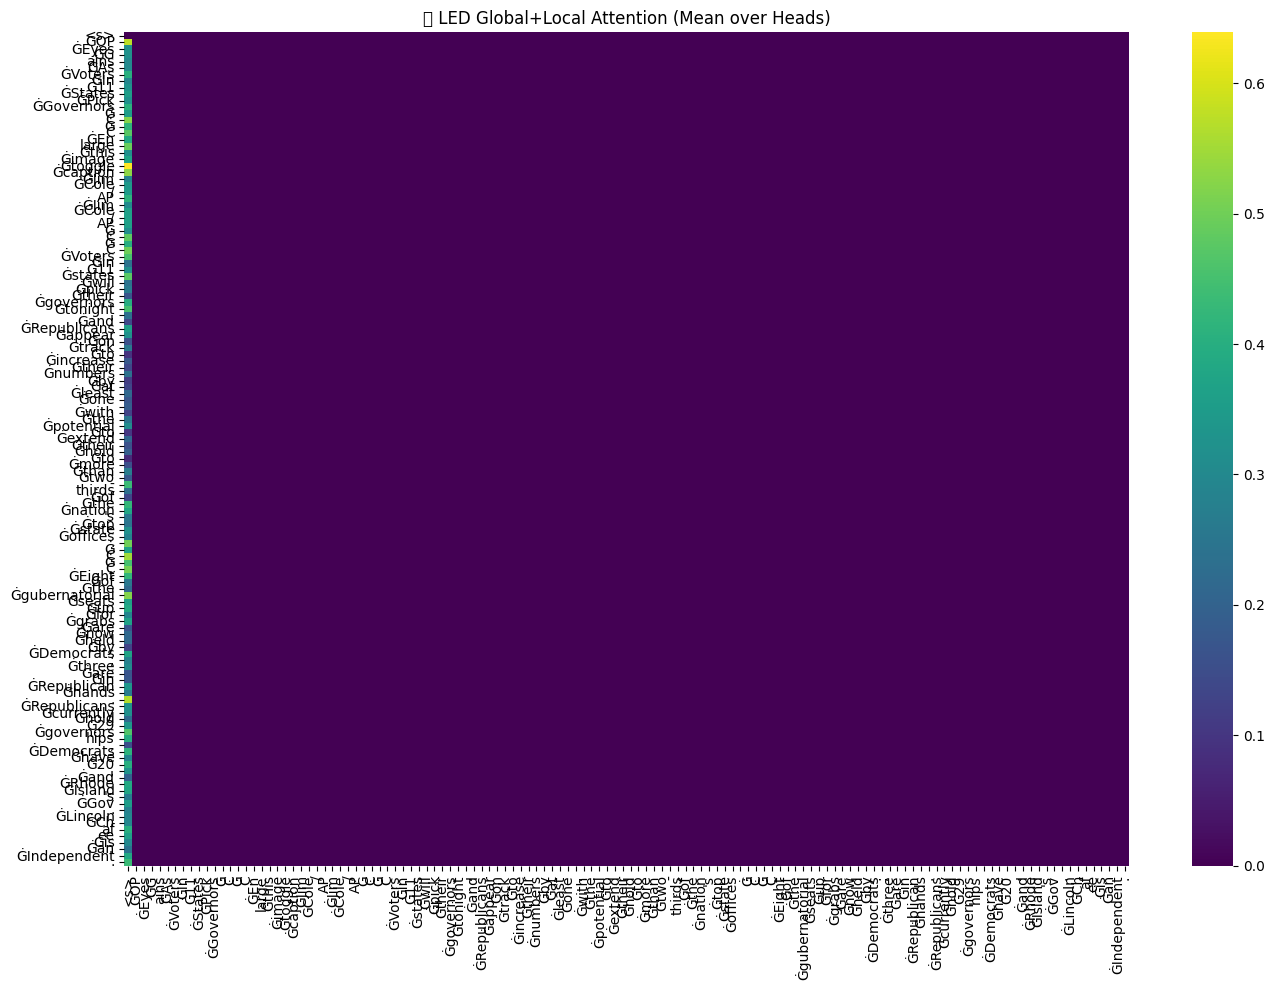

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize (first 128 tokens for readability)
num_tokens = 128
attn = encoder_attn[:num_tokens, :num_tokens]
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0][:num_tokens])

plt.figure(figsize=(14, 10))
sns.heatmap(attn.cpu(), xticklabels=tokens, yticklabels=tokens, cmap="viridis")
plt.title("🧠 LED Global+Local Attention (Mean over Heads)")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()